In [3]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import cm
%matplotlib inline
import os
import sys
from PIL import Image

sys.path.append('/eagle/MDClimSim/mjp5595/ml4dvar/stormer/')
from stormer_utils_pangu import StormerWrapperPangu
from varsStormer import varsStormer

save_dir_name = 'stormer_few_perturbs'
diffs = np.load('/eagle/MDClimSim/mjp5595/data/stormer/{}/diffs.npy'.format(save_dir_name))

save_dir = '/eagle/MDClimSim/mjp5595/data/stormer/{}/'.format(save_dir_name)
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
plot_dir = os.path.join(save_dir,'plots')
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

background_file_np = '/eagle/MDClimSim/mjp5595/ml4dvar/stormer/background_init_stormer_norm_hr12.npy' # This is just to initialize the model background
background_f = np.load(background_file_np, 'r')
print('background_f.shape :',background_f.shape)

noise_levels = [0, 0.01, 0.1, 1, 10, 100, 1000]

/home/mjp5595/.conda/envs/climaX/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
/home/mjp5595/.conda/envs/climaX/lib/python3.8/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


background_f.shape : (1, 69, 128, 256)


hf.keys() : <KeysViewHDF5 ['0', '102', '108', '114', '12', '120', '126', '132', '138', '144', '150', '156', '162', '168', '174', '18', '180', '186', '192', '198', '204', '210', '216', '222', '228', '234', '24', '240', '30', '36', '42', '48', '54', '6', '60', '66', '72', '78', '84', '90', '96']>
forecast_orig.shape : (69, 128, 256)
Plotting noise level : 0.01
Plotting noise level : 0.1
Plotting noise level : 1
Plotting noise level : 10
Plotting noise level : 100
Plotting noise level : 1000
Plotting noise level : 0.01
Plotting noise level : 0.1
Plotting noise level : 1
Plotting noise level : 10
Plotting noise level : 100
Plotting noise level : 1000
mse_arr : []
noise_mses : {0.01: 1944170200.0, 0.1: 1944170400.0, 1: 1944167800.0, 10: 1944155500.0, 100: 1944205000.0, 1000: 1946192500.0}
mse_arr : [1944170200.0, 1944170400.0, 1944167800.0, 1944155500.0, 1944205000.0, 1946192500.0]


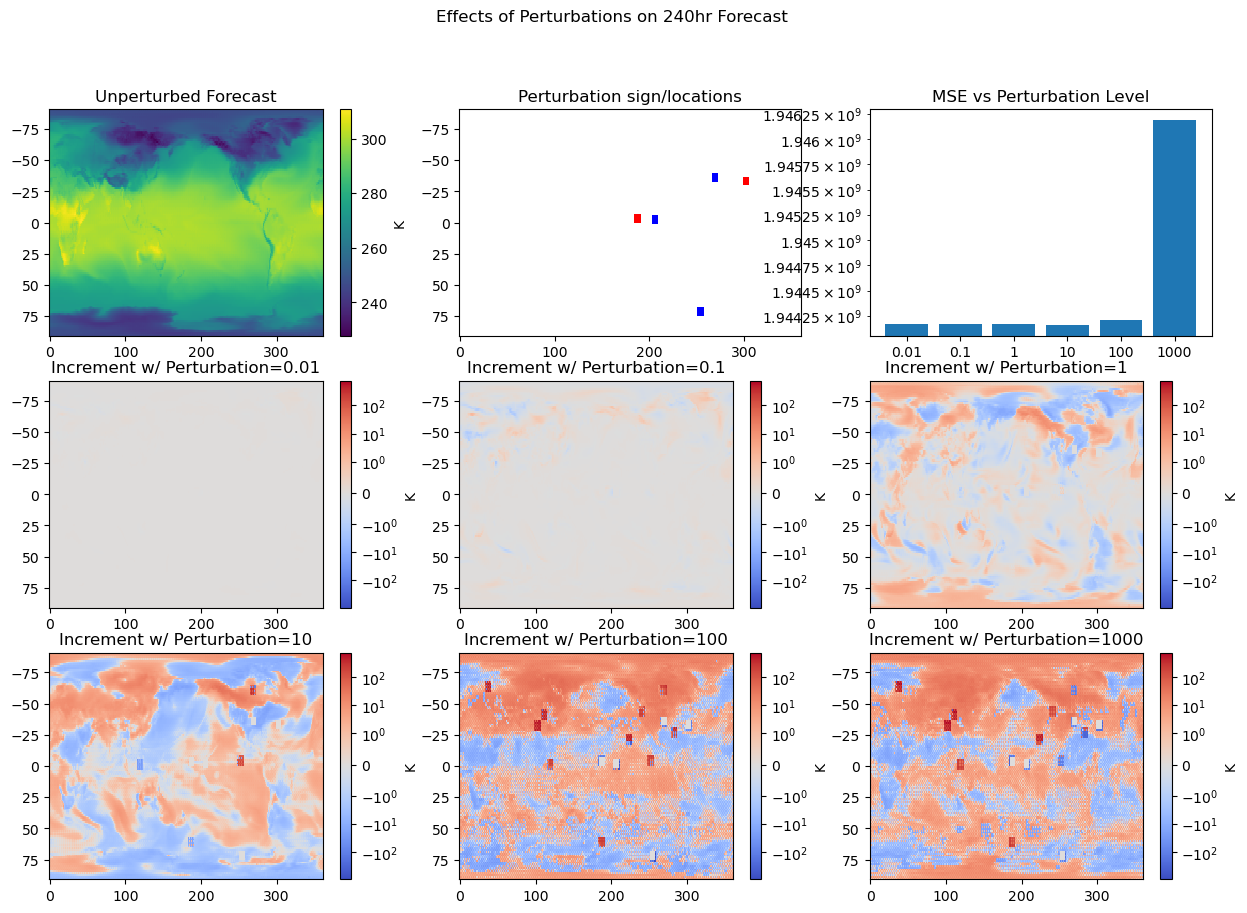

In [2]:
# Plotting the results
#forecast_step = 39 
forecast_step = '240'
lon = np.linspace(0,360,256)
lat = np.linspace(90,-90,128)

#fig, axs = plt.subplots(3, 3, sharex = True, sharey = True, figsize = (15,10))
#fig, axs = plt.subplots(3, 3, figsize = (15,10))
fig = plt.figure(figsize=(15,10))
axs = []

# Get original forecast
axs00 = fig.add_subplot(331)
axs.append(axs00)
hf = h5py.File(os.path.join(save_dir, 'raw_forecast_noise{}.h5'.format(noise_levels[0])),'r')
print('hf.keys() :',hf.keys())
#forecast_orig = hf[str(forecast_step)][0]
forecast_orig = hf[str(forecast_step)][:]
print('forecast_orig.shape :',forecast_orig.shape)
axs00.invert_yaxis()
pc_orig = axs00.pcolormesh(lon, lat, forecast_orig[0], cmap = 'viridis')
plt.colorbar(pc_orig, ax = axs00, label='K')
axs00.set_title('Unperturbed Forecast')

# plot perturbations
axs01 = fig.add_subplot(332, sharey=axs00, sharex=axs00)
axs.append(axs01)
perturbations = diffs[0]
cmap = colors.ListedColormap(['blue','white','red'])
bounds = [-1.5,-0.5,0.5,1.5]
#axs01.invert_yaxis()
perts = axs01.pcolormesh(lon, lat, perturbations[0], cmap=cmap)
axs01.set_title('Perturbation sign/locations')

######################################################################################################################
# This block is to get the min and max increment values
######################################################################################################################
inc_min = 0
inc_max = 0
for idx,noise_level in enumerate(noise_levels[1:]):
    print('Plotting noise level :',noise_level)
    hf = h5py.File(os.path.join(save_dir, 'raw_forecast_noise{}.h5'.format(noise_level)),'r')
    #forecast_perturbed = hf[str(forecast_step)][0]
    forecast_perturbed = hf[str(forecast_step)][:]

    increment = forecast_perturbed - forecast_orig
    increment = np.where(perturbations!=0,0,increment)
    inc_min = min(inc_min,np.min(increment[0]))
    inc_max = max(inc_max,np.max(increment[0]))
    #inc_min = min(inc_min,np.min(np.log(abs(increment))))
    #inc_max = max(inc_max,np.max(np.log(abs(increment))))
######################################################################################################################
######################################################################################################################

# get analysis and mse of perturbed forecasts
perts = []
noise_mses = {}
for idx,noise_level in enumerate(noise_levels[1:]):
    print('Plotting noise level :',noise_level)
    hf = h5py.File(os.path.join(save_dir, 'raw_forecast_noise{}.h5'.format(noise_level)),'r')
    forecast_perturbed = hf[str(forecast_step)][0]

    increment = forecast_perturbed - forecast_orig
    increment = np.where(perturbations!=0,0,increment)

    mse = np.mean(np.square(increment))
    noise_mses[noise_level] = mse

    str_int = '33' + str(idx+4)
    axs.append(fig.add_subplot(int(str_int), sharey=axs00, sharex=axs00))
    #axs[-1].invert_yaxis()
    #perts.append(axs[-1].pcolormesh(lon, lat, increment[0], cmap=cm.coolwarm, norm=colors.Normalize(inc_min,inc_max)))
    #perts.append(axs[-1].pcolormesh(lon, lat, increment[0], cmap='viridis', norm=colors.CenteredNorm(vmin=inc_min,vcenter=0,vmax=inc_max)))
    #perts.append(axs[-1].pcolormesh(lon, lat, increment[0], cmap=cm.coolwarm, norm=colors.CenteredNorm(vcenter=0)))

    #twoSlope = colors.TwoSlopeNorm(vmin=inc_min, vcenter=0, vmax=inc_max)
    #perts.append(axs[-1].pcolormesh(lon, lat, increment[0], cmap='viridis', norm=colors.LogNorm(inc_min,inc_max)))
    #perts.append(axs[-1].pcolormesh(lon, lat, increment[0], cmap=cm.coolwarm, norm=colors.SymLogNorm(linthresh=0.0001)))
    perts.append(axs[-1].pcolormesh(lon, lat, increment[0], cmap=cm.coolwarm, norm=colors.SymLogNorm(linthresh=1,vmin=inc_min,vmax=inc_max)))
    axs[-1].set_title('Increment w/ Perturbation={}'.format(noise_level))
    plt.colorbar(perts[-1], ax = axs[-1], label='K')

axs02 = fig.add_subplot(333)
axs.append(axs02)
#axs02._shared_y_axes.remove(axs[0, 2])
#axs02._shared_x_axes.remove(axs[0, 2])
axs02.set_yscale('log')
axs02.set_title('MSE vs Perturbation Level')
#mse_arr = np.zeros(len(noise_mses))
mse_arr = []
print('mse_arr :',mse_arr)
print('noise_mses :',noise_mses)
noise_levels_str = []
for idx,noise_level in enumerate(noise_levels[1:]):
    mse_arr.append(noise_mses[noise_level])
    noise_levels_str.append(str(noise_level))
print('mse_arr :',mse_arr)
#mse_scat = axs[0, 2].scatter(noise_levels[1:],mse_arr)
#mse_scat = axs[0, 2].bar(np.arange(len(noise_levels[1:])),noise_levels[1:],legend=mse_arr)
#mse_scat = axs[0, 2].bar(np.arange(len(noise_levels[1:])),noise_levels[1:])
mse_scat = axs02.bar(noise_levels_str,mse_arr)
#axs[0, 2].set_xlabel(noise_levels[1:])

plt.suptitle('Effects of Perturbations on 240hr Forecast')
plt.savefig(save_dir+'perturb_sameCMap_240hr.png')



hf.keys() : <KeysViewHDF5 ['0', '102', '108', '114', '12', '120', '126', '132', '138', '144', '150', '156', '162', '168', '174', '18', '180', '186', '192', '198', '204', '210', '216', '222', '228', '234', '24', '240', '30', '36', '42', '48', '54', '6', '60', '66', '72', '78', '84', '90', '96']>
perturbations.shape : (69, 128, 256)
var_lim_min : 222.31448
var_lim_max : 318.82147
inc_lim_min : inf
inc_lim_max : 0.30181885


var_lim_min : 94653.414
var_lim_max : 104436.125
inc_lim_min : inf
inc_lim_max : 60.09375
var_lim_min : 45273.824
var_lim_max : 58355.805
inc_lim_min : inf
inc_lim_max : 78.390625
var_lim_min : 222.3075
var_lim_max : 318.82925
inc_lim_min : inf
inc_lim_max : 3.1889038
var_lim_min : 94567.77
var_lim_max : 104477.66
inc_lim_min : inf
inc_lim_max : 388.85938
var_lim_min : 45273.824
var_lim_max : 58357.66
inc_lim_min : inf
inc_lim_max : 450.1289
var_lim_min : 221.83961
var_lim_max : 318.98178
inc_lim_min : inf
inc_lim_max : 16.187042


KeyboardInterrupt: 

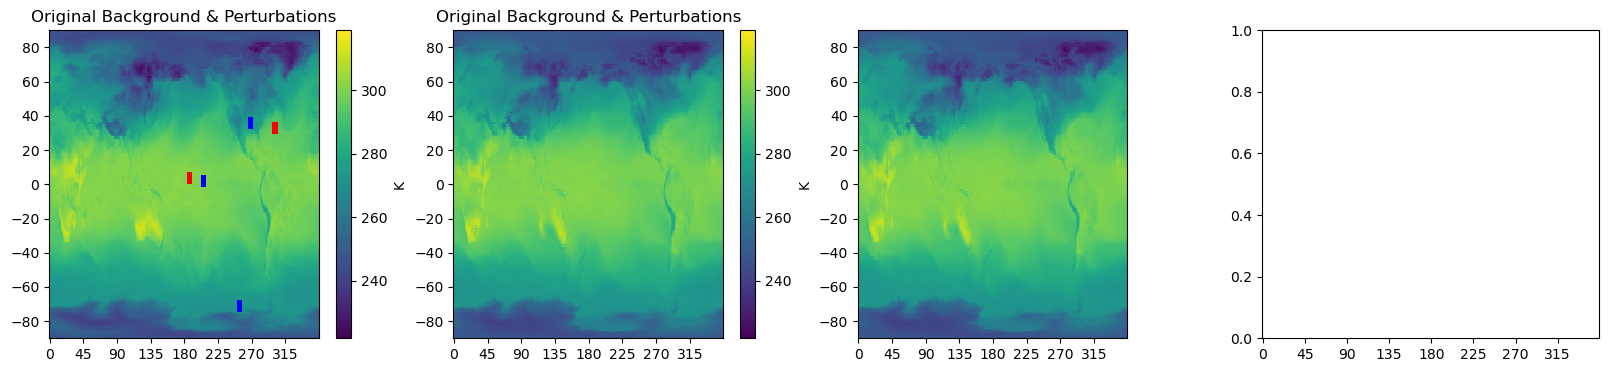

In [35]:
vars_stormer = varsStormer().vars_stormer
vars_units = varsStormer().var_units

forecast_scales = np.arange(0,246,6)

forecast_orig = h5py.File(os.path.join(save_dir, 'raw_forecast_noise{}.h5'.format(noise_levels[0])),'r')
print('hf.keys() :',hf.keys())

perturbations = diffs[0]
print('perturbations.shape :',perturbations.shape)

lat = np.load('/eagle/MDClimSim/troyarcomano/1.40625deg_npz_40shards/lat.npy')
lon = np.load('/eagle/MDClimSim/troyarcomano/1.40625deg_npz_40shards/lon.npy')

for nl_idx,nl in enumerate(noise_levels[1:]):
    noise_dir = os.path.join(plot_dir,'noise_{}'.format(nl))
    if not os.path.exists(noise_dir):
        os.makedirs(noise_dir)

    for var_idx in [0,3,11]:
        gif_files = []

        gif_dir = os.path.join(noise_dir,'{}_gifs'.format(vars_stormer[var_idx]))
        if not os.path.exists(gif_dir):
            os.makedirs(gif_dir)

        forecast_perturb = h5py.File(os.path.join(save_dir, 'raw_forecast_noise{}.h5'.format(nl)),'r')

        var_lim_min = float(np.inf)
        var_lim_max = float(-np.inf)
        inc_lim_min = float(np.inf)
        inc_lim_max = float(-np.inf)
        inc_mse_max = 0
        for fs in forecast_scales:
            forecast_perturb_clean = np.where(perturbations[var_idx]!=0,forecast_orig[str(fs)][var_idx],forecast_perturb[str(fs)][var_idx])
            var_lim_min = min(var_lim_min,np.min(forecast_orig[str(fs)][var_idx]),np.min(forecast_perturb_clean))
            var_lim_max = max(var_lim_max,np.max(forecast_orig[str(fs)][var_idx]),np.max(forecast_perturb_clean))
            #inc_lim_min = min(inc_lim_min,np.min(ana_fc[str(fs)][var_idx]-bg_fc[str(fs)][var_idx]))
            increment = forecast_perturb_clean - forecast_orig[str(fs)][var_idx]
            inc_lim_max = max(inc_lim_max,np.max(np.abs(increment)))
            inc_mse_max = max(inc_mse_max,np.mean(np.square(increment)))
        print('var_lim_min :',var_lim_min)
        print('var_lim_max :',var_lim_max)
        print('inc_lim_min :',inc_lim_min)
        print('inc_lim_max :',inc_lim_max)

        mse_x = []
        mse_y = []
        for i,fs in enumerate(forecast_scales):
            fig_gif, axs_gif = plt.subplots(1,4,sharex = True, sharey = False, figsize=(20,4))
            pc_era50 = axs_gif[0].pcolormesh(lon, lat, forecast_orig[str(0)][var_idx], cmap='viridis', vmin=var_lim_min, vmax=var_lim_max)
            plt.colorbar(pc_era50, ax = axs_gif[0],label=vars_units[var_idx])
            axs_gif[0].set_title('Original Background & Perturbations')
            axs_gif[0].set_xticks(np.linspace(0,360,9))

            pc_perturb = axs_gif[0].pcolormesh(lon, lat, perturbations[var_idx], cmap='bwr', vmin=-1, vmax=1, alpha=np.abs(perturbations[var_idx]))

            pc_era50 = axs_gif[1].pcolormesh(lon, lat, forecast_orig[str(fs)][var_idx], cmap='viridis', vmin=var_lim_min, vmax=var_lim_max)
            plt.colorbar(pc_era50, ax = axs_gif[1],label=vars_units[var_idx])
            axs_gif[1].set_title('Original Background & Perturbations')
            axs_gif[1].set_xticks(np.linspace(0,360,9))

            forecast_perturb_clean = np.where(perturbations[var_idx]!=0,forecast_orig[str(fs)][var_idx],forecast_perturb[str(fs)][var_idx])
            increment = forecast_perturb_clean - forecast_orig[str(fs)][var_idx]

            pc_ana0 = axs_gif[2].pcolormesh(lon, lat, forecast_perturb_clean, cmap='viridis', vmin=var_lim_min, vmax=var_lim_max)
            plt.colorbar(pc_ana0, ax = axs_gif[2],label=vars_units[var_idx])
            axs_gif[2].set_title('Perturbed Forecast {}hrs'.format(fs))
            axs_gif[2].get_yaxis().set_ticklabels([])

            pc_inc0 = axs_gif[3].pcolormesh(lon, lat, increment, 
                                        cmap='RdYlBu_r', vmin=-inc_lim_max, vmax=inc_lim_max)
            plt.colorbar(pc_inc0, ax = axs_gif[3], label=vars_units[var_idx])
            axs_gif[3].set_title('Increment (Perturb - GT_Pred) {}hrs'.format(fs))
            axs_gif[3].set_yticks([])

            axs_mses = axs_gif[3].twinx()
            axs_mses.set_ylim(0,inc_mse_max)
            axs_mses.yaxis.tick_left()
            axs_mses.yaxis.set_label_position('left')
            axs_mses.set_ylabel('Mean Squared Increment ({})'.format(vars_units[var_idx]))
            mse_x.append(i*(359/(len(forecast_scales)-1)))
            mse_y.append(np.mean(np.square(increment)))
            axs_mses.plot(mse_x,mse_y,c='k')

            fig_gif.suptitle('Stormer Perturbed Forecasts ({}) - Noise Level {}'.format(vars_stormer[var_idx],nl))
            plt.tight_layout()

            plt.savefig(os.path.join(gif_dir,'{}.png'.format(i)))
            plt.close()

            gif_files.append(os.path.join(gif_dir,'{}.png'.format(i)))

        gif_imgs = []
        for gif_f in gif_files:
            gif_imgs.append(Image.open(gif_f))

        # create extra copies of the frist and last frame
        for x in range(0, 5):
            im = gif_imgs[0]
            gif_imgs.insert(0,im)
            im = gif_imgs[-1]
            gif_imgs.append(im)

        gif_imgs[0].save(os.path.join(gif_dir,'stormer_perturbed_forecasts_{}_noise{}.gif'.format(vars_stormer[var_idx],nl)),
                    save_all=True, append_images=gif_imgs[1:], optimize=False, duration=500, loop=0)

In [22]:

var_idx = 0

px_1 = []
py_1 = []
px_m1 = []
py_m1 = []
for row in range(len(perturbations[var_idx])):
    for col in range(len(perturbations[var_idx,row])):
        if perturbations[var_idx,row,col] > 0:
            px_1.append(col)
            py_1.append(row)
        elif perturbations[var_idx,row,col] < 0:
            px_m1.append(col)
            py_m1.append(row)

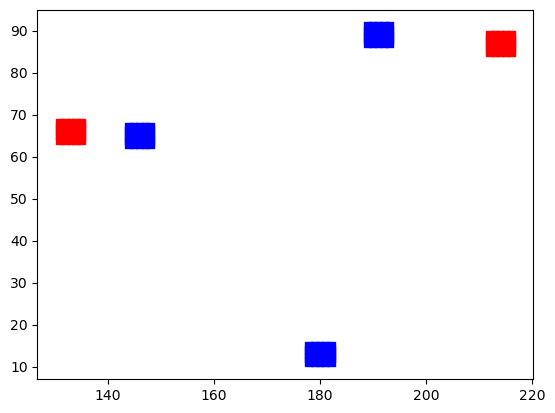

In [23]:
plt.scatter(px_1,py_1,marker='s',c='r')
plt.scatter(px_m1,py_m1,marker='s',c='b')

In [19]:
px_1

[64,
 64,
 64,
 64,
 64,
 65,
 65,
 65,
 65,
 65,
 66,
 66,
 66,
 66,
 66,
 67,
 67,
 67,
 67,
 67,
 68,
 68,
 68,
 68,
 68,
 85,
 85,
 85,
 85,
 85,
 86,
 86,
 86,
 86,
 86,
 87,
 87,
 87,
 87,
 87,
 88,
 88,
 88,
 88,
 88,
 89,
 89,
 89,
 89,
 89]

In [21]:
py_1

[64,
 64,
 64,
 64,
 64,
 65,
 65,
 65,
 65,
 65,
 66,
 66,
 66,
 66,
 66,
 67,
 67,
 67,
 67,
 67,
 68,
 68,
 68,
 68,
 68,
 85,
 85,
 85,
 85,
 85,
 86,
 86,
 86,
 86,
 86,
 87,
 87,
 87,
 87,
 87,
 88,
 88,
 88,
 88,
 88,
 89,
 89,
 89,
 89,
 89]